In [2]:
import math, keras
from PIL import Image

import numpy as np
np.float_ = np.float64

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# import tensorrt
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.98)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
print(tf.config.list_physical_devices('GPU'))


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D

from tensorflow.keras.applications.convnext import ConvNeXtXLarge

import matplotlib.pyplot as plt
%matplotlib inline 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1750229399.005649  134216 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15628 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
# name = 'Dubai'
# name = 'CatDog'

# Каталог с данными для обучения
train_dir = f'/media/pendrive/dataset-bigWM/train'
# Каталог с данными для проверки
val_dir = f'/media/pendrive/dataset-bigWM/validation'
# Каталог с данными для тестирования
# test_dir = f'dataset/test'
# Размеры изображения
img_width, img_height = 224, 224
# Размер мини-выборки
batch_size = 16
# число классов
num_classes = 2

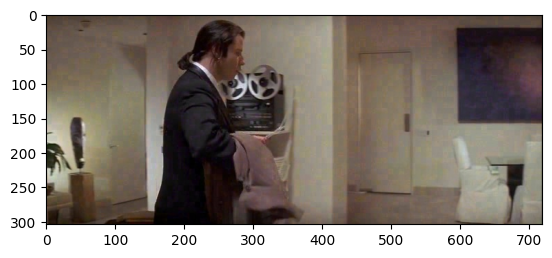

In [52]:
# image_file_name = train_dir + '/1/3.jpg' # with watermark
image_file_name = train_dir + '/wm-china/47681-13.jpg' # with watermark
img = Image.open(image_file_name)
plt.imshow(img)

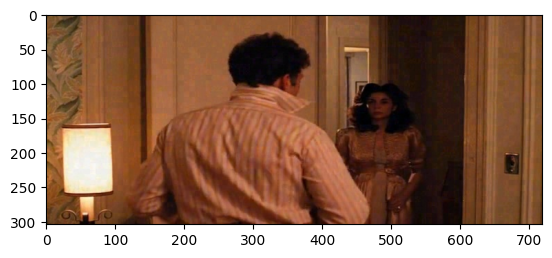

In [53]:
image_file_name = val_dir + '/wm-china/164713-12.jpg' # with watermark
img = Image.open(image_file_name)
plt.imshow(img)

In [54]:
train_datagen = ImageDataGenerator()#(rescale=1. / 255)#, featurewise_center=True, featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 936150 images belonging to 2 classes.


In [55]:
test_datagen = ImageDataGenerator()#(rescale=1. / 255)#, featurewise_center=True, featurewise_std_normalization=True)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 200000 images belonging to 2 classes.


In [56]:
def model_maker(activation):

    base_model = ConvNeXtXLarge(include_top=False, input_shape = (img_width, img_height, 3))
    
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
        
    input = Input(shape=(img_width, img_height, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    # custom_model = Dense(128, activation='relu')(custom_model)
    # custom_model = Dropout(0.5)(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    # custom_model = Dense(32, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(num_classes, activation=activation)(custom_model) # activation = 'sigmoid', activation = 'softmax'
    return Model(inputs=input, outputs=predictions)

In [57]:
model = model_maker('sigmoid') #softmax

model.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_xlarge (Functional)    │ (None, 7, 7, 2048)     │   348,147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,279,234 (1.30 GB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 348,147,968 (1.30 GB)

In [58]:
from keras import metrics

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[metrics.mae, metrics.categorical_accuracy])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy', # 'categorical_crossentropy',
              metrics=['accuracy',
                       metrics.AUC(name='auc'),
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.TruePositives(name='TP'),
                       metrics.TrueNegatives(name='TN'),
                       metrics.FalsePositives(name='FP'),
                       metrics.FalseNegatives(name='FN')])

In [59]:
# Обучаем модель с использованием генераторов
# train_generator - генератор данных для обучения
# validation_data - генератор данных для проверки

callback = tf.keras.callbacks.EarlyStopping(monitor='auc', min_delta=0.0001, patience=500)

# Need to run with real data to infer shape of different layers
history = model.fit(train_generator,
                    steps_per_epoch=6,
                    epochs=1_000_000,
                    validation_data=val_generator,
                    validation_steps=1,
                    callbacks=[callback])


Epoch 1/1000000
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - FN: 26.8571 - FP: 37.5714 - TN: 24.1429 - TP: 34.8571 - accuracy: 0.4847 - auc: 0.5242 - loss: 0.7492 - precision: 0.4659 - recall: 0.5362 - val_FN: 5.0000 - val_FP: 5.0000 - val_TN: 11.0000 - val_TP: 11.0000 - val_accuracy: 0.8125 - val_auc: 0.6582 - val_loss: 0.6523 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 2/1000000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step - FN: 22.2857 - FP: 33.1429 - TN: 28.5714 - TP: 39.4286 - accuracy: 0.5448 - auc: 0.5808 - loss: 0.7300 - precision: 0.5457 - recall: 0.6503 - val_FN: 8.0000 - val_FP: 8.0000 - val_TN: 8.0000 - val_TP: 8.0000 - val_accuracy: 0.5000 - val_auc: 0.5352 - val_loss: 0.7262 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/1000000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - FN: 29.4286 - FP: 34.4286 - TN: 27.2857 - TP: 32.2857 - accuracy: 0.4378 - auc: 0.4381 - loss: 0.8022 - precision: 0.4653 - recall: 0.5077 - val_FN: 7.0000 - val_FP: 9.0000 - val_TN: 7.0000 - val_TP: 9.000

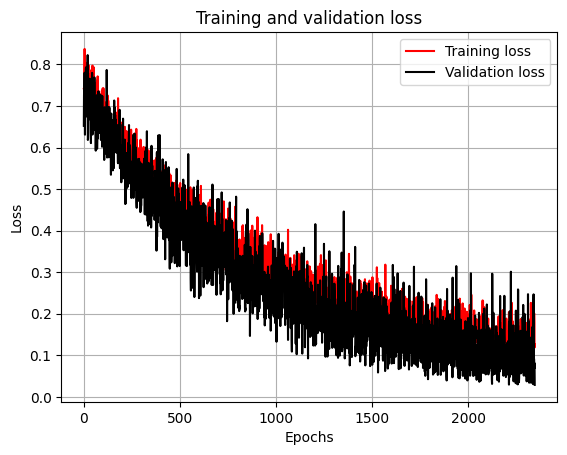

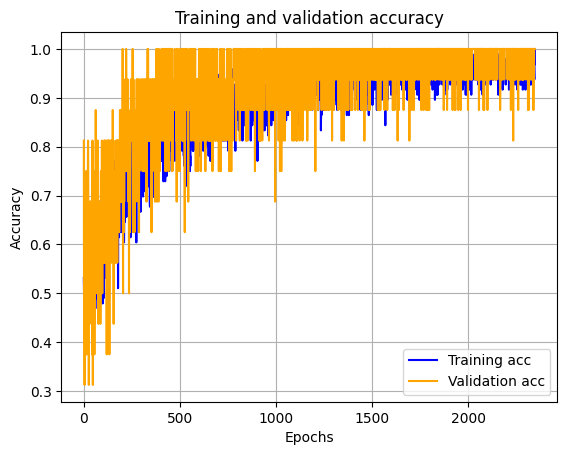

In [60]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(f'loss-china-orig-bigWM-train-delta0.0001.png')
plt.show()

epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'blue', label='Training acc')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(f'acc-china-orig-bigWM-train-delta0.0001.png')
plt.show()

In [61]:
test_dir = f'/media/pendrive/dataset-bigWM/test' # from China with code
# test_dir = f'dataset/test_split_wm_afterTG_30'
# test_dir = f'dataset/test_split_wm_afterTG_30_random'
# test_dir = f'dataset/test_split_wm_afterTG_50'
# test_dir = f'dataset/test_split_wm_afterTG_70'
# test_dir = f'dataset/test_split_wm_beforeTG_30'

In [62]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2002 images belonging to 2 classes.


In [63]:
scores = model.evaluate(test_generator)
# print(f"\nТочность на тестовых данных: {(scores[1]*100):.2f}%")

126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - FN: 25.1339 - FP: 23.4488 - TN: 1000.2047 - TP: 998.5197 - accuracy: 0.9772 - auc: 0.9972 - loss: 0.1016 - precision: 0.9764 - recall: 0.9729


In [64]:
print(model.metrics_names)
print(scores)

['loss', 'compile_metrics']
[0.1013009175658226, 0.9775224924087524, 0.9974812269210815, 0.977477490901947, 0.9755244851112366, 1953.0, 1957.0, 45.0, 49.0]


In [65]:
from math import sqrt
mcc = (scores[-4]*scores[-3] - scores[-2]*scores[-1])/sqrt((scores[-4]+scores[-2])*(scores[-4]+scores[-1])*(scores[-3]+scores[-2])*(scores[-3]+scores[-1]))
print(f'Коэффициент корреляции Мэтьюса = {mcc}')

Коэффициент корреляции Мэтьюса = 0.9530488553400775


In [66]:
# model.save('pretrained-classificator-wm-coco-advanced128-64.keras')
model.save('pretrained-classificator-wm.keras')

In [67]:
test_dir = f'/media/pendrive/dataset-bigWM/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
scores = model.evaluate(test_generator)
print(scores)
mcc = (scores[-4]*scores[-3] - scores[-2]*scores[-1])/sqrt((scores[-4]+scores[-2])*(scores[-4]+scores[-1])*(scores[-3]+scores[-2])*(scores[-3]+scores[-1]))
print(f'Коэффициент корреляции Мэтьюса = {mcc}')

Found 2002 images belonging to 2 classes.
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - FN: 24.0709 - FP: 20.9843 - TN: 1002.6693 - TP: 999.5827 - accuracy: 0.9772 - auc: 0.9979 - loss: 0.0995 - precision: 0.9786 - recall: 0.9740
[0.1013009175658226, 0.9775224924087524, 0.9974812269210815, 0.977477490901947, 0.9755244851112366, 1953.0, 1957.0, 45.0, 49.0]
Коэффициент корреляции Мэтьюса = 0.9530488553400775


In [93]:
from keras import metrics

# model = keras.models.load_model("pretrained-classificator-wm-coco-advanced128-64.keras")
model = keras.models.load_model("pretrained-classificator-wm.keras")
# model = keras.models.load_model("pretrained-classificator-wm-coco.keras")
print("Loaded model from disk")

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', # 'categorical_crossentropy',
              metrics=['accuracy',
                       metrics.AUC(name='auc'),
                       metrics.Precision(name='precision'), 
                       metrics.TruePositives(), 
                       metrics.TrueNegatives(), 
                       metrics.FalsePositives(), 
                       metrics.FalseNegatives()])

test_dir = '/media/pendrive/dataset-bigWM/test'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Loaded model from disk
Found 170 images belonging to 2 classes.


In [94]:
scores = model.evaluate(test_generator)
print(model.metrics_names)
print(scores)

from math import sqrt
mcc = (scores[-4]*scores[-3] - scores[-2]*scores[-1])/sqrt((scores[-4]+scores[-2])*(scores[-4]+scores[-1])*(scores[-3]+scores[-2])*(scores[-3]+scores[-1]))
print(f'Коэффициент корреляции Мэтьюса = {mcc}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.5350 - auc: 0.6568 - false_negatives_19: 46.6667 - false_positives_19: 45.7500 - loss: 0.9333 - precision: 0.5435 - true_negatives_19: 55.9167 - true_positives_19: 55.0000
['loss', 'compile_metrics']
[0.9379733800888062, 0.5411764979362488, 0.6581661105155945, 0.5470588207244873, 93.0, 93.0, 77.0, 77.0]
Коэффициент корреляции Мэтьюса = 0.09411764705882353


In [10]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Загрузка модели
model = load_model("pretrained-classificator-wm.keras")

# Загрузка и подготовка изображения
img_path = 'test_wm_dwtDct.png'  # Укажите путь к вашему изображению
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Добавьте размерность для батча
# img_array /= 255.0  # Нормализация

# Предсказание
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: [1]


In [7]:
# Загрузка и подготовка изображения
img_path = 'test_wm_dwtDctSvd.png'  # Укажите путь к вашему изображению
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Добавьте размерность для батча
# img_array /= 255.0  # Нормализация

# Предсказание
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: [1]


In [8]:
# Загрузка и подготовка изображения
img_path = 'test_wm_rivaGan.png'  # Укажите путь к вашему изображению
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Добавьте размерность для батча
# img_array /= 255.0  # Нормализация

# Предсказание
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: [0]


In [9]:
# Загрузка и подготовка изображения
img_path = 'test.png'  # Укажите путь к вашему изображению
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Добавьте размерность для батча
# img_array /= 255.0  # Нормализация

# Предсказание
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: [0]
